# TLC Trip Record Data

## Objective
To predict the ride duration based on the various data from customers. For practice purpose, I will build simple model to use for practice basic MLOps.

## Data source
The dataset can be downloaded in [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).
For data dictionary, it can be found in [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).


In [1]:
!python -V

Python 3.9.7


RMSE of validation sets (subset of train sets): 5.529
RMSE of validation sets (Feb 2022 data): 5.904


,trip_distance,fare_amount,duration,prediction
0,1.16,5.5,4.150000,8.001963
1,0.57,4.5,3.083333,7.241583
2,0.00,42.2,27.283333,35.907759
3,16.62,49.0,41.650000,41.078417
4,5.97,21.0,23.333333,19.787822


<AxesSubplot:xlabel='duration', ylabel='Count'>

<AxesSubplot:xlabel='duration', ylabel='Count'>

(0.0, 60.0)

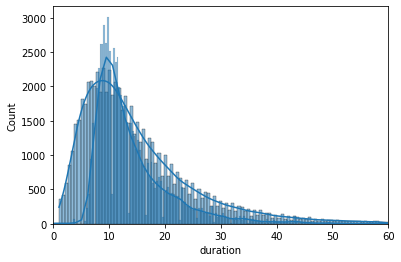

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

SEED = 0

def load_dataset(path):
    """
    Return the dataset in pandas dataframe format with lowercase columns
    and each column name seperated by underscore.
    
    Args:
    * path, str: file directory or file link of dataset
    
    Output:
    * pd.DataFrame
    
    Notes:
    This function is used to read a parquet format.
    If the format is not parquet, change the first line of code.
    
    """
    df = pd.read_parquet(path)
    df.columns = [inflection.underscore(var) for var in list(df.columns)]    
    return df

def target_variable(df):
    """
    Return the target variable, which in this case is ride duration in minutes.
    duration = lpep_dropoff_datetime - lpep_pickup_datetime.
    
    Args:
    * df, pd.DataFrame: the dataset
    
    Output:
    * pd.DataFrame: contain the target variable
    
    Notes:
    * For practice purpose, the ride duration to be used only in the range 1 to 60 minutes.
    """
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df['duration'] = df['duration'].dt.total_seconds() / 60
    return df[(df['duration'] >= 1) & (df['duration'] <= 60) ]

def dataset_summary(df):
    """
    Return the following information from dataset:
    variable name, number of unique value, pandas dtype, 
    number of missing values, percentage of missing values, 
    and list of unique values.
    
    Args:
    * df, pd.DataFrame: the dataset
    
    Output:
    * table, pd.DataFrame
    """
    table = pd.DataFrame(
                columns=['variable',
                         'no_unique',
                         'pandas_dtype',
                         'missing_value',
                         '%_missing_values',
                         'unique_value'
                ]
    )

    for i, var in enumerate(df.columns):
        table.loc[i] = [var,
                        df[var].nunique(),
                        df[var].dtypes,
                        df[var].isnull().sum(),
                        df[var].isnull().sum() * 100 / df.shape[0],
                        df[var].unique().tolist()
        ]
    return table

def train_the_model(df, target='duration', test_size=0.2, seed=SEED):
    """
    Return the saved model.
    
    Args:
    * df, pd.DataFrame: the dataset
    * target, str (optional): target variable, default value is 'duration'
    * test_size, float (optional): fraction of test set size, default value is 0.2
    * seed, int (optional): random number for reproducibility, default value is 0
    
    Output:
    * rmse, float: model evaluation metric
    
    Notes:
    * Only use two features such as trip_distance and fare_amount 
      and only use LinearRegression to build a model.
    * The dataset are splitted into two sets with ratio 80% train and
      20% validation sets.
    
    """
    X_train, X_val, y_train, y_val = train_test_split(
        df[['trip_distance', 'fare_amount']],
        df[target],
        test_size=test_size,
        random_state=seed
    )
    model = make_pipeline(
        MinMaxScaler(),
        LinearRegression()
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"RMSE of validation sets (subset of train sets): {rmse:.3f}")
    return model

def save_the_model(model):
    """
    Save the machine learning model that contains preprocessor and regressor/classifier.
    
    Args:
    * model, .bin: model pipeline to predict unseen data later
    
    Output:
    * None
    """
    with open("../model/linear_regression.bin", 'wb') as file_out:
         joblib.dump(model, file_out)

def load_the_model(path):
    """
    Load the trained model from directory
    
    Args:
    * path, str: trained model directory
    
    Output:
    * model, ... : a loaded model
    """
    with open("../model/linear_regression.bin", 'rb') as file_in:
         model = joblib.load(file_in)
    
    return model

def main():
    """
    Notes:
    * Use data from Jan 2022 for training then use Feb 2022 data for validation.
    """
    # load the dataset
    train = load_dataset("../dataset/green_tripdata_2022-01.parquet")
    train = target_variable(train)
    
    val = load_dataset("../dataset/green_tripdata_2022-02.parquet")
    val = target_variable(val)

    # train the model and save it
    model = train_the_model(train, target='duration', test_size=0.2)
    save_the_model(model)

    # test the trained model to unseen data 
    # note: actually 'unseen_data' is not real unseen data, to be updated later
    trained_model = load_the_model("../model/linear_regression.bin")
    unseen_data = val[["trip_distance", "fare_amount", "duration"]].copy()
    
    features = unseen_data.drop("duration", axis=1)
    unseen_data['prediction'] = trained_model.predict(features)
    rmse = mean_squared_error(unseen_data['duration'], unseen_data['prediction'], squared=False)
    print(f"RMSE of validation sets (Feb 2022 data): {rmse:.3f}")

    display(
        unseen_data.head(),
        sns.histplot(data=unseen_data, x='duration', kde=True, palette="DADADA"),
        sns.histplot(data=unseen_data, x='prediction', kde=True, palette="1F1F1F"),
        plt.xlim([0, 60]),
    )
    
main()